# Business Understanding

## Project Domain

membuat website yang bisa menebak kondisi jalanan (macet, lancar, atau ramai) berdasarkan data jumlah kendaraan (mobil, sepeda, bus, truk) dan jamnya. Aplikasi ini pakai machine learning buat prediksi.

## Problem Statements

menghadapi macet pasti tidak nyaman kita tidak bisa nebak kapan jalanan bakal ramai atau kosong. Data jumlah kendaraan sering ada tapi tidak dipakai buat prediksi yang akurat. Akibatnya, orang sering terjebak macet atau salah ambil rute.

## Goals

buat website simpel yang bisa kasih tau kondisi jalanan ("macet", "normal", atau "lancar") berdasarkan input jumlah kendaraan dan jam.

Bantu pengendara lalu lintas ngambil keputusan (contoh "Sekarang jam 6 sore, jumlah kepadatan lalu lintas sepi, langsung berkendara").

mengurangi kebiasaan nebak-nebak soal situasi jalanan.

## Solution Statements

Bisa input data jumlah kendaraan (mobil, sepeda, bus, truk) dan jam (0-23), Pakai model machine learning sederhana buat prediksi kondisi jalanan.
Bisa menampilkan hasil prediksi dalam bahasa mudah "Situasi Lalu Lintas Diprediksi: normal".

# Data Understanding

## Import data dari kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khafidhilham20","key":"8677bb72f9f6a3701287828d4127d1f0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d hasibullahaman/traffic-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/hasibullahaman/traffic-prediction-dataset
License(s): other
  0% 0.00/83.1k [00:00<?, ?B/s]
100% 83.1k/83.1k [00:00<00:00, 116MB/s]


In [ ]:
!unzip /content/traffic-prediction-dataset.zip -d 221351065


Archive:  /content/traffic-prediction-dataset.zip
  inflating: 221351065/Traffic.csv   
  inflating: 221351065/TrafficTwoMonth.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import pickle
import os

In [ ]:
df = pd.read_csv('/content/221351065/TrafficTwoMonth.csv')

In [ ]:
(df.head())

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal


## Import Library yang dibutuhkan

## Exploratory Data Analysis

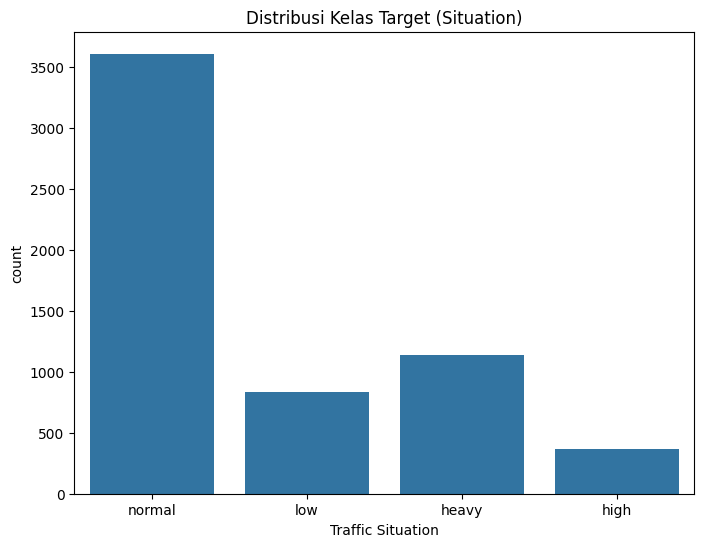

In [ ]:
# EDA KE 1
plt.figure(figsize=(8,6))
sns.countplot(x='Traffic Situation', data=df)
plt.title('Distribusi Kelas Target (Situation)')
plt.show()

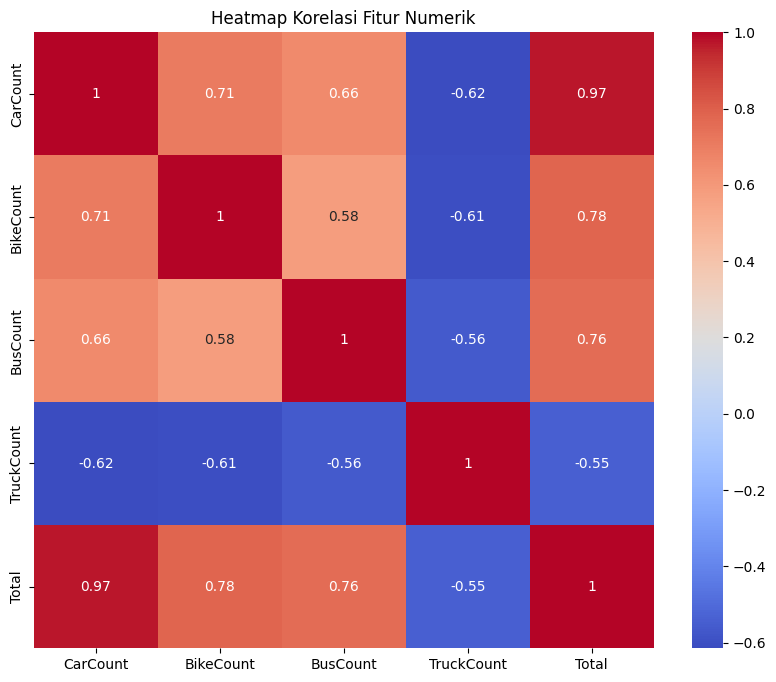

In [ ]:
#EDA KE 2
numeric_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

<ipython-input-10-69144c6fb85d>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


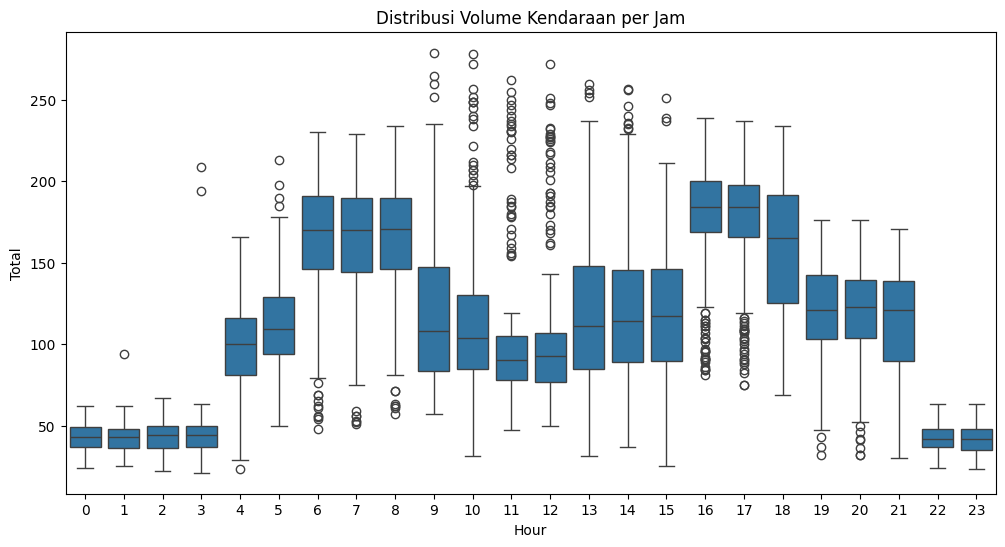

In [ ]:
#EDA KE 3
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
plt.figure(figsize=(12,6))
sns.boxplot(x='Hour', y='Total', data=df)
plt.title('Distribusi Volume Kendaraan per Jam')
plt.show()

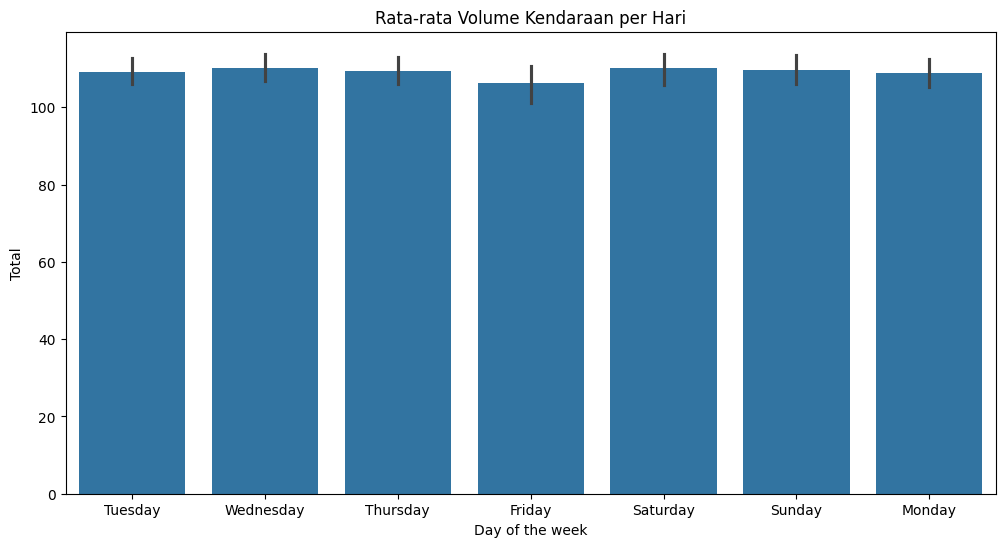

In [ ]:
#EDA KE 4
plt.figure(figsize=(12,6))
sns.barplot(x='Day of the week', y='Total', data=df, estimator=np.mean)
plt.title('Rata-rata Volume Kendaraan per Hari')
plt.show()

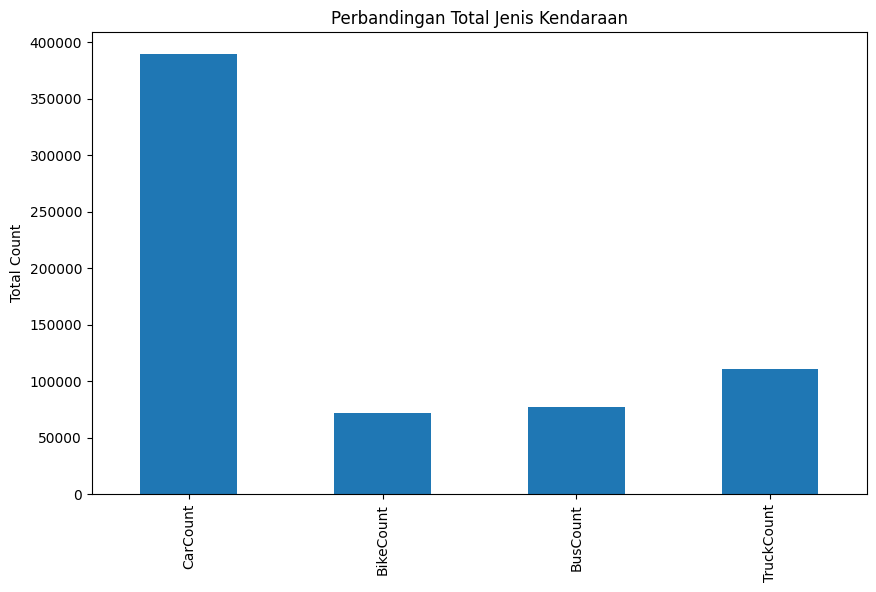

In [ ]:
#EDA KE 5
vehicle_types = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
df[vehicle_types].sum().plot(kind='bar', figsize=(10,6))
plt.title('Perbandingan Total Jenis Kendaraan')
plt.ylabel('Total Count')
plt.show()

# Data Preparation

In [ ]:
features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour']
X = df[features]

y = df['Traffic Situation']

In [ ]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Simpan label encoder untuk deployment
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Scaling Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan scaler untuk deployment
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Modeling

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,660 (10.39 KB)

 Trainable params: 2,660 (10.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5575 - loss: 1.0713 - val_accuracy: 0.7566 - val_loss: 0.5665
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7990 - loss: 0.5467 - val_accuracy: 0.8625 - val_loss: 0.3727
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8545 - loss: 0.3879 - val_accuracy: 0.8930 - val_loss: 0.2892
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8829 - loss: 0.3092 - val_accuracy: 0.9035 - val_loss: 0.2590
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8855 - loss: 0.2782 - val_accuracy: 0.9087 - val_loss: 0.2405
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9079 - loss: 0.2672 - val_accuracy: 0.9129 - val_loss: 0.2183
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9072 - loss: 0.2379 - val_accuracy: 0.9171 - val_loss: 0.2158
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9050 - loss: 0.2555 - val_accu

# Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'akurasi y: {test_acc*100:.2f}%')

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9893 - loss: 0.0349
akurasi y: 98.82%


# Deployment

## Model Simulation

In [ ]:
 # Load model dan preprocessing objects
def predict_traffic(input_data):
    # Load model dan preprocessing objects
    with open('label_encoder.pkl', 'rb') as f:
        le = pickle.load(f)
    with open('scaler.pkl', 'rb') as f:
        sc = pickle.load(f)


In [ ]:
 converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('traffic_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpe5kgeu5j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138083340794960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138083340794192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138083340794768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138083340793616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138083340793808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138083340792272: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Save Model

In [ ]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Traffic Situation'])

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)